# MOM6 input file idealised case

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# First define grid
NI, NJ, NK = 800, 400, 2 # number of points in zonal, meridional and vertical levels
LENLON, LENLAT = 3200., 1600. # in km 
MAXIMUM_DEPTH = 4000.   # in m 
WESTLON, SOUTHLAT = 0.0, 0.0

X = np.linspace(WESTLON, WESTLON + LENLON - 0*LENLON/NI, NI)
Y = np.linspace(SOUTHLAT, SOUTHLAT + LENLAT - 0*LENLAT/NJ, NJ)
#Z = [k for k in range(NK)]

Xm, Ym = np.meshgrid(X,Y)

In [26]:
def flat_bottom():
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    return D

def guassian_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.exp(-((Xm - LENLON/2)/sigma)**2)
    ridge = ridge*H0/np.max(ridge)
    D = D - ridge
    return D

def zero_velocity():
    u = np.zeros((NK,NJ,NI))
    v = np.zeros((NK,NJ,NI))
    return u,v

def wind_stress(tau_0):
    taux = tau_0*np.sin(np.pi*Ym/LENLAT)**2
    tauy = np.zeros((NJ,NI))
    return taux, tauy


# Returns an array h[k,j,i] representing the layer thickness of the k-th layer at (lat,lon) 
# and an array eta[k,j,i] with the heights of each interface.
# Note that h has NK values in the vertical while eta has NK+1 values.
# k = 0 is the surface layer, with increasing k descending down the layers.
# h[i,j,k] >= ANGSTROM, which is the minimum layer thickness.
# input : D[i,j], a two-dimensional array of the depth of the ocean.
def layer_thickness(eta0, depth):
    eta = np.zeros((NK+1,NJ,NI))
    h = np.zeros((NK,NJ,NI))
    
    eta[NK-1,:,:] = -MAXIMUM_DEPTH/2.
    eta[NK,:,:] = - depth
    
    for k in range(0,NK):
        h[k,:,:] = eta[k,:,:] - eta[k+1,:,:]
        
    return h, eta

In [35]:
tau_0 = 0.15
taux, tauy = wind_stress(tau_0)

ridge_h0 = 400.
sigma = 1000.

Rd = 20000
f = -10**-4
gp = Rd**2*MAXIMUM_DEPTH*f**2/((MAXIMUM_DEPTH/2)**2/4)

rho_0 = 1031.0
rho_1 = gp*rho_0/9.8 + rho_0

density = [1031.0, rho_1]

depth = guassian_ridge_bottom(ridge_h0, sigma)

eta0 = [0., -MAXIMUM_DEPTH/2., -MAXIMUM_DEPTH]
h, eta = layer_thickness(eta0, depth)

In [40]:
print(h.shape, eta.shape)
print(density)
print(eta[2,:,:])

(2, 400, 800) (3, 400, 800)
[1031.0, 1032.6832653061224]
[[-3969.07797983 -3968.67963462 -3968.27717552 ... -3968.27717552
  -3968.67963462 -3969.07797983]
 [-3969.07797983 -3968.67963462 -3968.27717552 ... -3968.27717552
  -3968.67963462 -3969.07797983]
 [-3969.07797983 -3968.67963462 -3968.27717552 ... -3968.27717552
  -3968.67963462 -3969.07797983]
 ...
 [-3969.07797983 -3968.67963462 -3968.27717552 ... -3968.27717552
  -3968.67963462 -3969.07797983]
 [-3969.07797983 -3968.67963462 -3968.27717552 ... -3968.27717552
  -3968.67963462 -3969.07797983]
 [-3969.07797983 -3968.67963462 -3968.27717552 ... -3968.27717552
  -3968.67963462 -3969.07797983]]


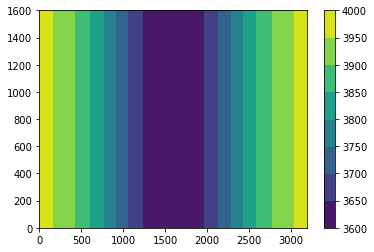

In [48]:
#plt.contourf(X,Y,taux.transpose())
#plt.colorbar()

plt.contourf(X,Y,depth)
plt.colorbar()

#plt.plot(Y, tau_0*np.sin(np.pi*Y/LENLAT)**2)
#plt.plot(Y, tau_0*np.sin(2*np.pi*Y/LENLAT))

(400, 800)
(400, 800)
1.603810890548638e-28
1.603810890548638e-28
0.0
-3.6739403974420595e-17


0.0

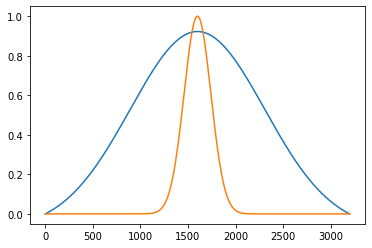

In [20]:
print(taux.shape)
print(depth.shape)
#Ym.shape
#Xm

a = tau_0*np.sin(2*np.pi*Y/LENLAT)
#np.sum(a)

ridge1 = np.exp(-((X - LENLON/2)/1000.)**2) 
ridge1 = ridge1 - np.min(ridge1)
ridge2 = np.exp(-((X - LENLON/2)/200.)**2)
plt.plot(X,ridge1)
plt.plot(X, ridge2)
print(ridge2[0])
print(ridge2[-1])

print(a[0])
print(a[-1])
np.sum(a)


In [49]:
# Save data to nc file
ds = xr.Dataset(
        data_vars={'taux':    (('lat', 'lon'), taux),
                   'tauy': (('lat', 'lon'), tauy),
                   'depth':    (('lat', 'lon'), depth),
                  'h': (('level', 'lat', 'lon'), h),
                  'eta': (('interface','lat', 'lon'), eta)},
        coords={'lat': Y, 'lon': X, 'depth_list': eta0, 'level': density})

ds.lat.attrs['units'] = 'km'
ds.lon.attrs['units'] = 'km'
ds.depth_list.attrs['units'] = 'm'
ds.level.attrs['units'] = 'kg m-3'
ds.depth.attrs['units'] = 'm'
ds.taux.attrs['units'] = 'N m-2'
ds.tauy.attrs['units'] = 'N m-2'
ds.h.attrs['units'] = 'm'
ds.eta.attrs['units'] = 'm'

ds.lon.attrs['standard_name'] = 'Longitude'
ds.lat.attrs['standard_name'] = 'Latitude'
ds.depth_list.attrs['standard_name'] = 'Mean Interface Height'
ds.level.attrs['standard_name'] = 'Mean Layer Density'
ds.depth.attrs['standard_name'] = 'Total Depth'
ds.taux.attrs['standard_name'] = 'Zonal Wind Stress'
ds.tauy.attrs['standard_name'] = 'Meridional Wind Stress'
ds.h.attrs['standard_name'] = 'Layer Depth'
ds.eta.attrs['standard_name'] = 'Interface Height'

ds.to_netcdf(path='/home/Hemant.Khatri/Work/input.nc')

In [51]:
ds

<xarray.Dataset>
Dimensions:     (depth_list: 3, interface: 3, lat: 400, level: 2, lon: 800)
Coordinates:
  * lat         (lat) float64 0.0 4.01 8.02 ... 1.592e+03 1.596e+03 1.6e+03
  * lon         (lon) float64 0.0 4.005 8.01 ... 3.192e+03 3.196e+03 3.2e+03
  * depth_list  (depth_list) float64 0.0 -2e+03 -4e+03
  * level       (level) float64 1.031e+03 1.033e+03
Dimensions without coordinates: interface
Data variables:
    taux        (lat, lon) float64 0.0 0.0 0.0 ... 2.25e-33 2.25e-33 2.25e-33
    tauy        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    depth       (lat, lon) float64 3.969e+03 3.969e+03 ... 3.969e+03 3.969e+03
    h           (level, lat, lon) float64 2e+03 2e+03 ... 1.969e+03 1.969e+03
    eta         (interface, lat, lon) float64 0.0 0.0 ... -3.969e+03 -3.969e+03